## New pipeline branch

In [13]:
from utils import Encoder
import utils
import torch
from datasets import RoboEireanDataModule
import lightning.pytorch as pl
from PIL import ImageDraw, Image
import os

from models import JetNet, SingleShotDetector, ObjectDetectionTask
from lightning.pytorch.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch.nn.functional as F
import torchvision.transforms as T

from visualize import draw_bounding_box

In [20]:
from PIL import Image, ImageDraw

def draw_bounding_boxes(image, bounding_boxes):
    # Open the image\
    draw = ImageDraw.Draw(image)
    width, height = image.size
    
    # Iterate over the bounding boxes
    for bbox in bounding_boxes:
        # Extract the box coordinates
        x_center, y_center, box_width, box_height = bbox
        
        # Convert YOLO coordinates to absolute coordinates
        x_min = (x_center - box_width / 2) * width
        y_min = (y_center - box_height / 2) * height
        x_max = (x_center + box_width / 2) * width
        y_max = (y_center + box_height / 2) * height
        
        # Draw the bounding box
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red")
    
    return image


#### Load model checkpoint and data

In [24]:
LEARNING_RATE = 1e-1
ALPHA = 2.0
NUM_CLASSES = 1
DEFAULT_SCALINGS = torch.tensor(
    [
        [0.06549374, 0.12928654],
        [0.11965626, 0.26605093],
        [0.20708716, 0.38876095],
        [0.31018215, 0.47485098],
        [0.415882, 0.8048184],
        [0.7293086, 0.8216225],
    ]
)
encoder = Encoder(DEFAULT_SCALINGS, NUM_CLASSES)
model = JetNet(NUM_CLASSES, DEFAULT_SCALINGS.shape[0])
loss = SingleShotDetector(ALPHA)

version = 91

checkpoint = os.listdir(f"new_logs/lightning_logs/version_{version}/checkpoints")[0]
checkpoint_path = f"new_logs/lightning_logs/version_{version}/checkpoints/{checkpoint}"
print(checkpoint_path)

loaded_model = ObjectDetectionTask.load_from_checkpoint(
    checkpoint_path=checkpoint_path, 
    model=model, 
    loss=loss, 
    encoder=encoder, 
    learning_rate=LEARNING_RATE)
loaded_model

# get the data we want to visualize and predict on
data_module = RoboEireanDataModule("data/raw/", encoder, 128)
data_module.setup("fit")  # TODO: inspect different stages

new_logs/lightning_logs/version_91/checkpoints/epoch=15-step=1776.ckpt


### Helper Function

#### Iterate over all data and check for positive predictions

data/raw/val/images/len_goalie0203.png


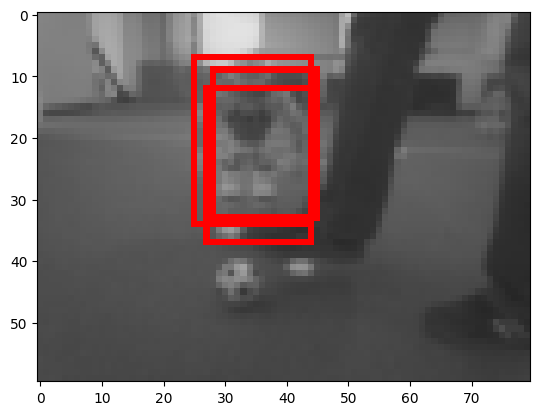

data/raw/val/images/len_goalie0258.png


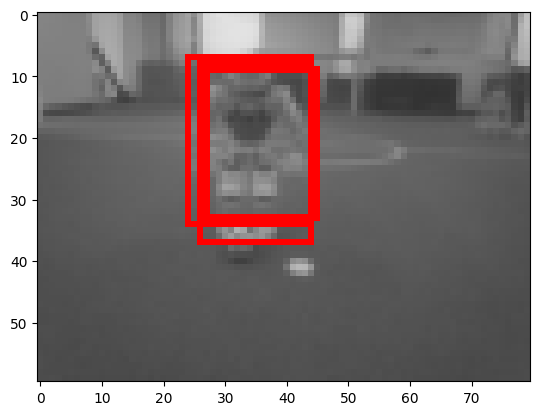

data/raw/val/images/len_goalie0417.png


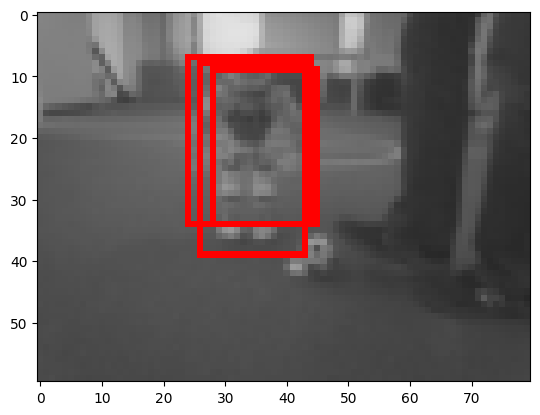

data/raw/val/images/len_goalie0459.png


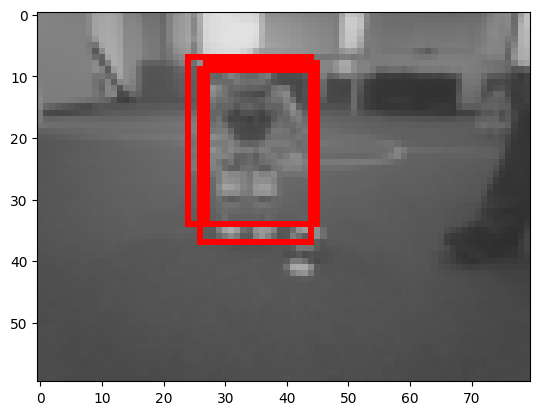

data/raw/val/images/len_goalie0460.png


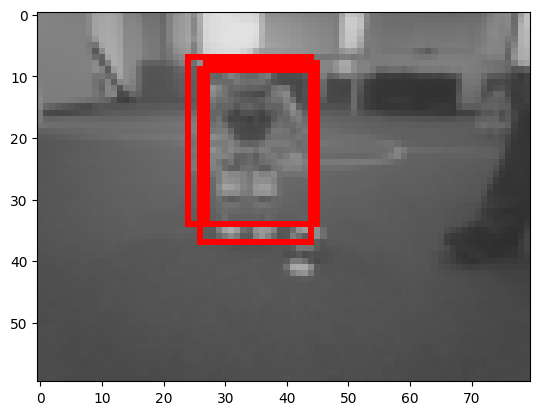

data/raw/val/images/len_goalie0471.png


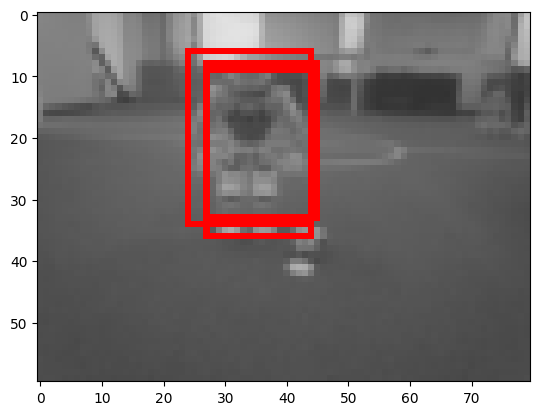

data/raw/val/images/len_goalie0477.png


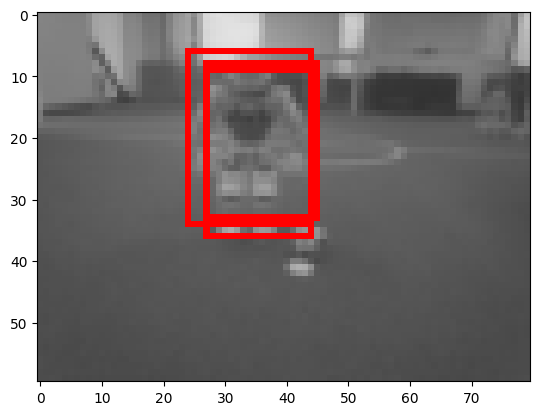

data/raw/val/images/max_ball_moving0053.png


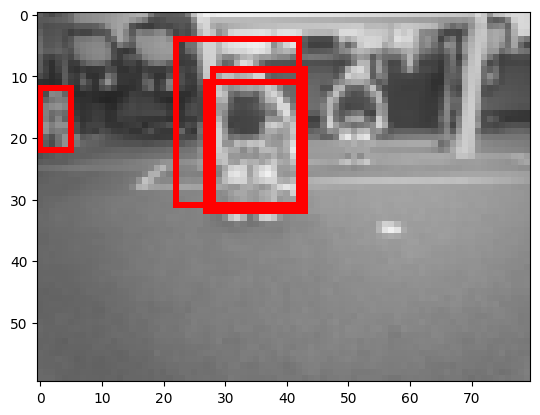

data/raw/val/images/max_ball_moving0158.png


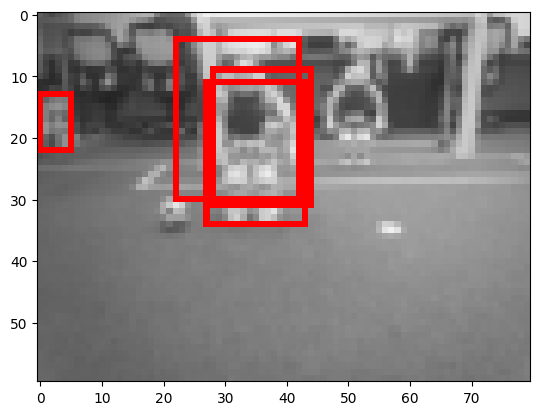

data/raw/val/images/max_ball_moving0253.png


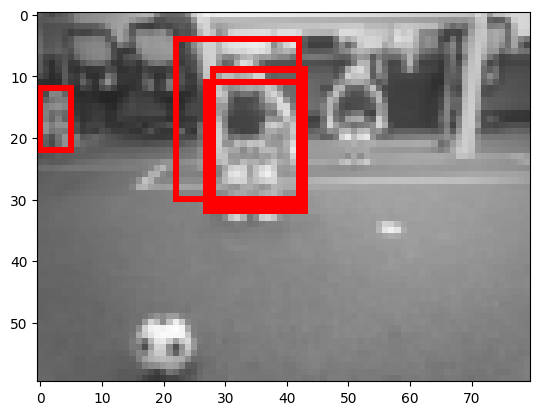

data/raw/val/images/max_ball_moving0256.png


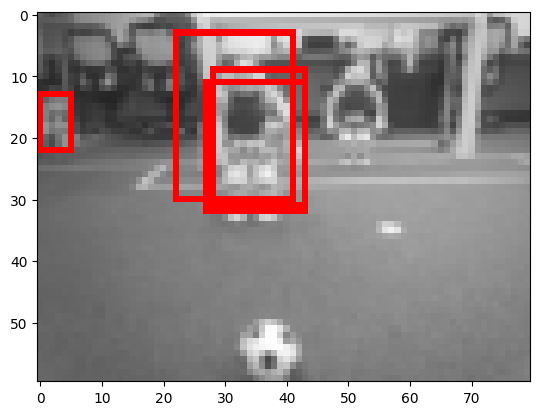

data/raw/val/images/max_ball_moving0365.png


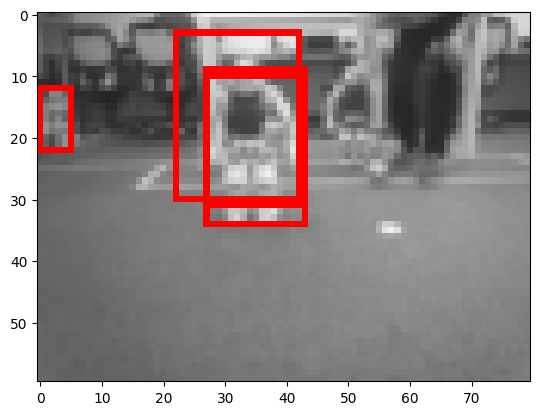

data/raw/val/images/max_ball_moving0367.png


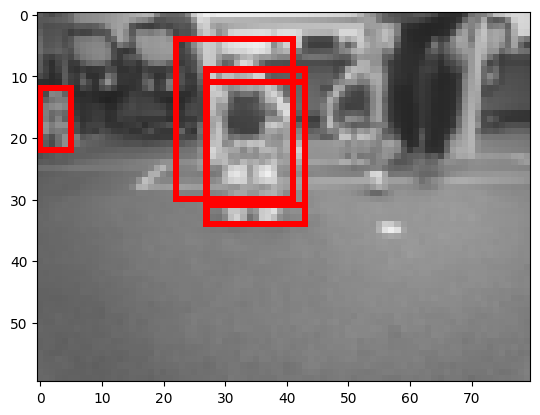

data/raw/val/images/max_ball_moving0371.png


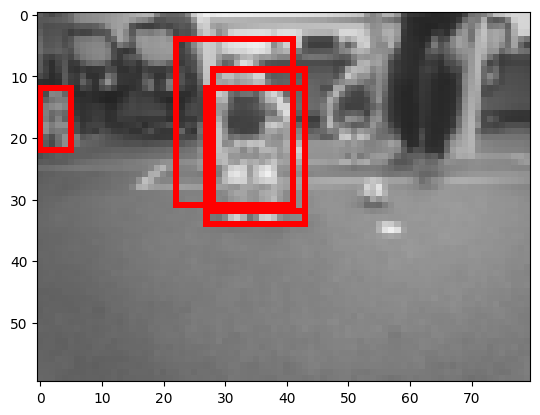

data/raw/val/images/max_ball_moving0378.png


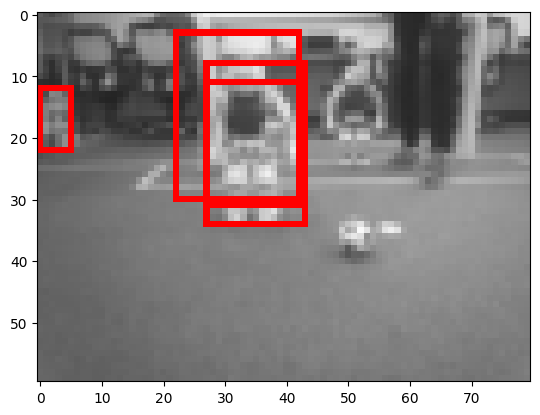

data/raw/val/images/max_ball_moving0382.png


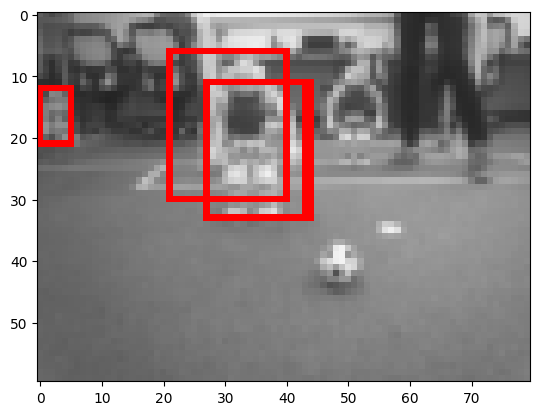

data/raw/val/images/max_ball_moving0390.png


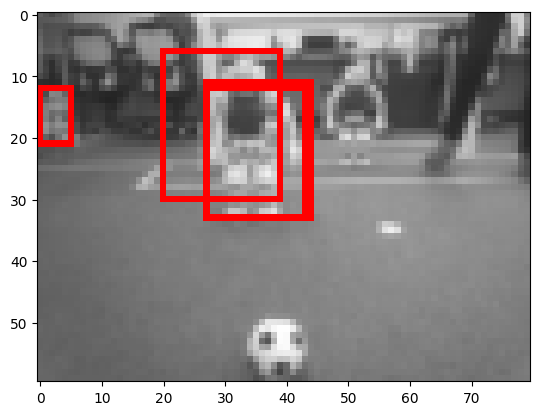

data/raw/val/images/max_ball_moving0464.png


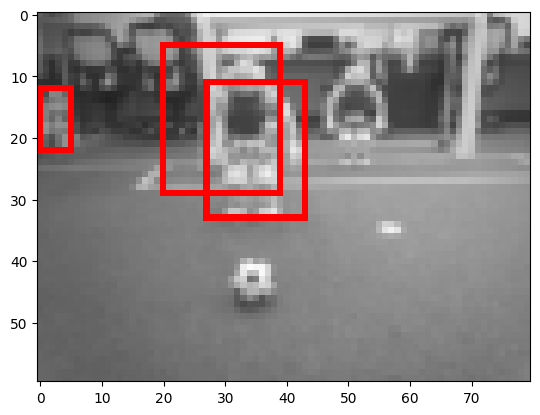

data/raw/val/images/max_ball_moving0466.png


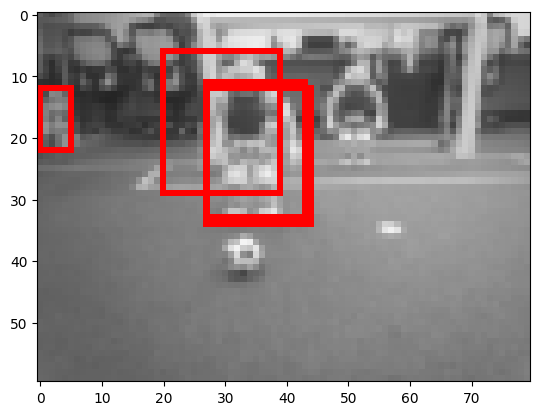

data/raw/val/images/max_ball_moving0474.png


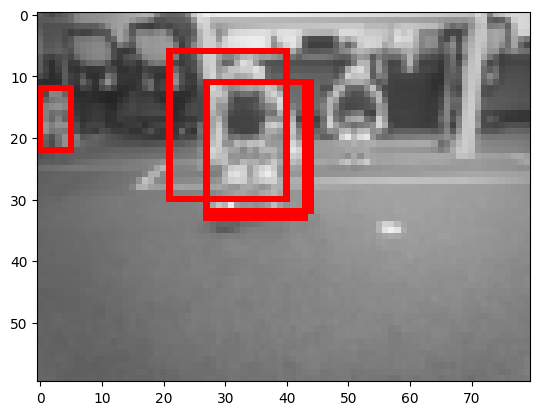

data/raw/val/images/max_ball_moving0494.png


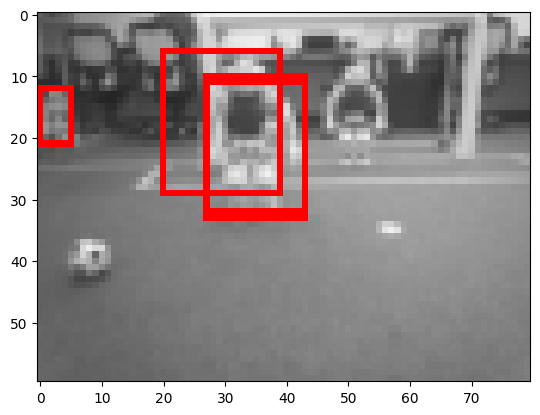

data/raw/val/images/max_ball_moving0502.png


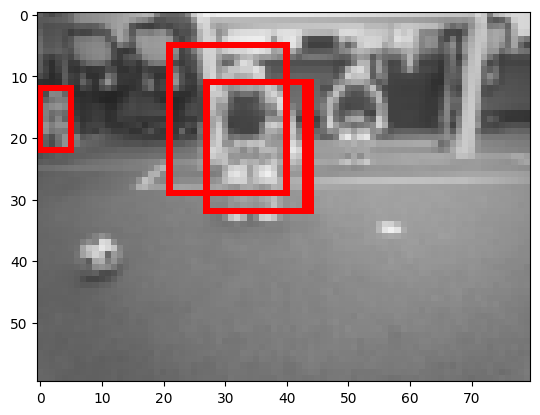

data/raw/val/images/max_ball_moving0510.png


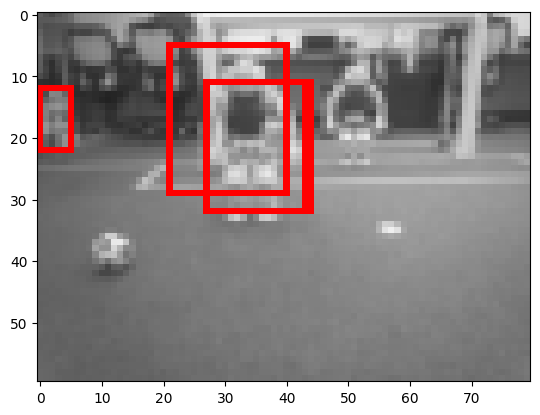

data/raw/val/images/pip_ball_bottom0229.png


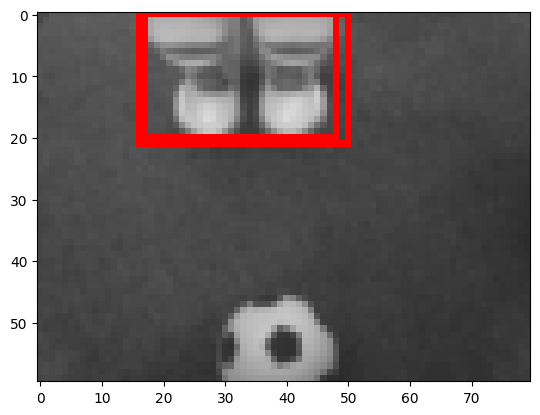

data/raw/val/images/pip_ball_bottom0261.png


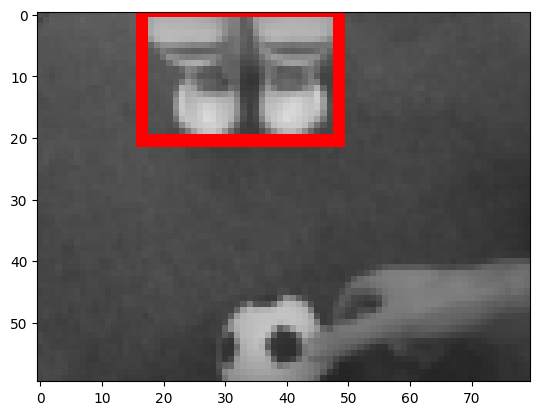

data/raw/val/images/pip_ball_bottom0291.png


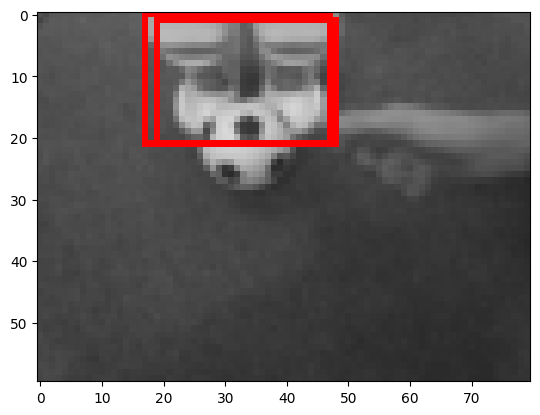

data/raw/val/images/robby_ball_far0001.png


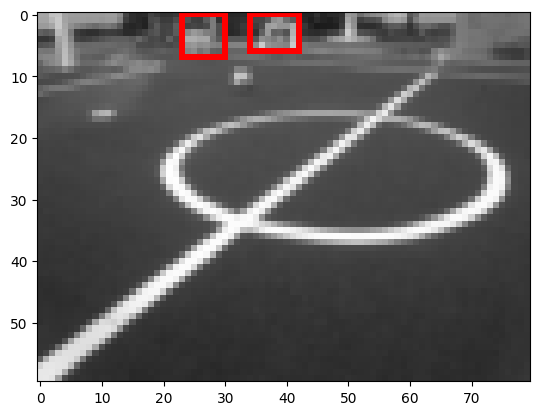

data/raw/val/images/robby_ball_far0030.png


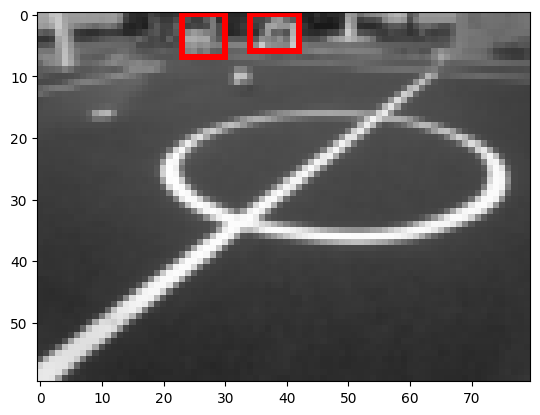

data/raw/val/images/robby_ball_far0120.png


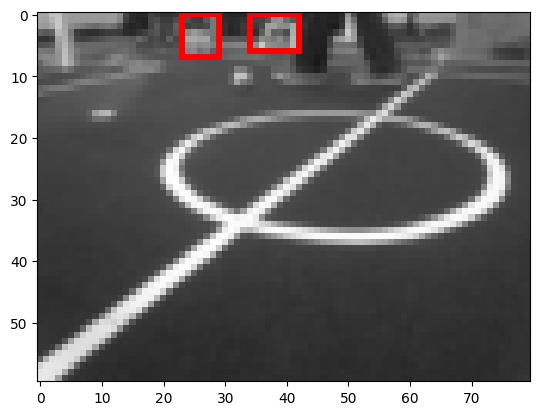

data/raw/val/images/robby_ball_far0327.png


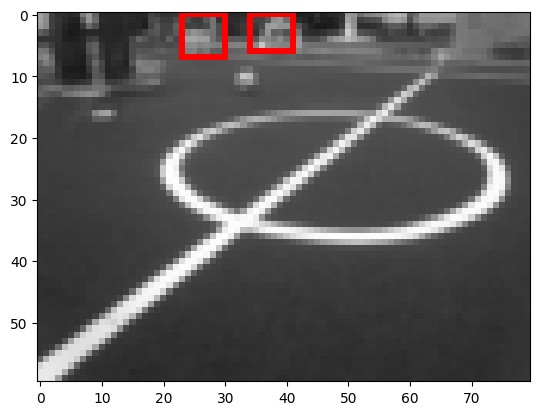

data/raw/val/images/robby_ball_far0351.png


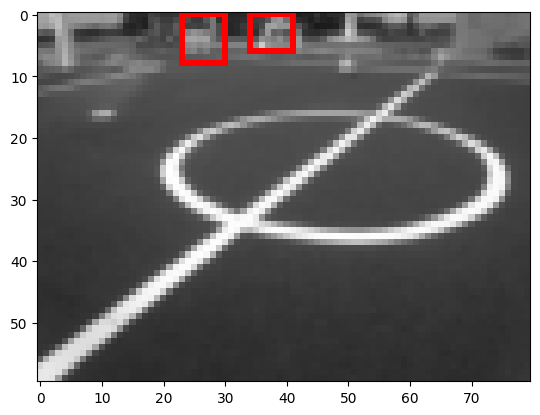

data/raw/val/images/robby_ball_far0354.png


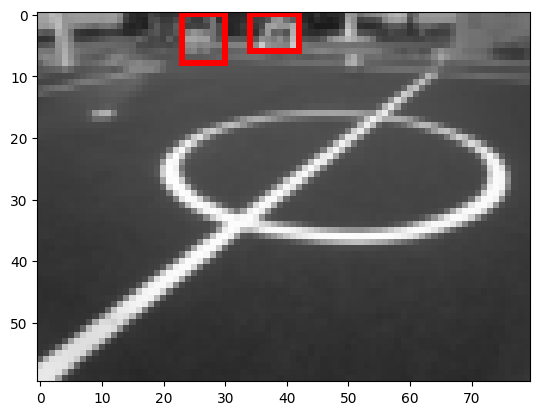

data/raw/val/images/robby_ball_far0395.png


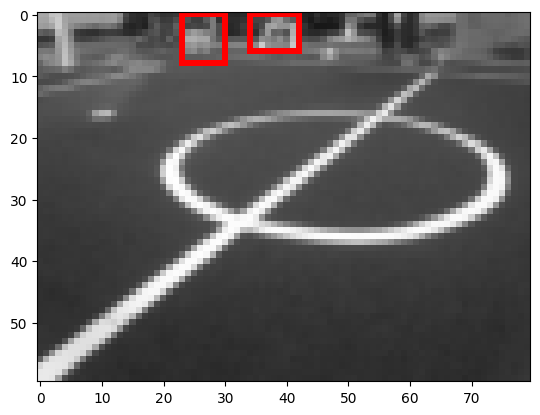

data/raw/val/images/robby_ball_far0405.png


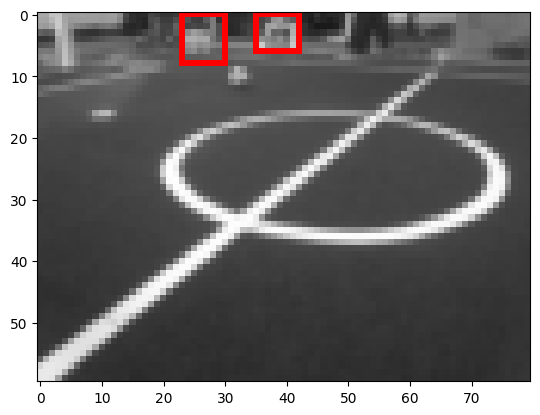

data/raw/val/images/robby_ball_far0419.png


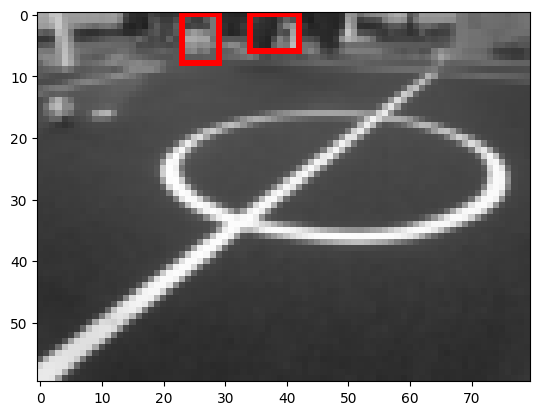

data/raw/val/images/robby_ball_far0573.png


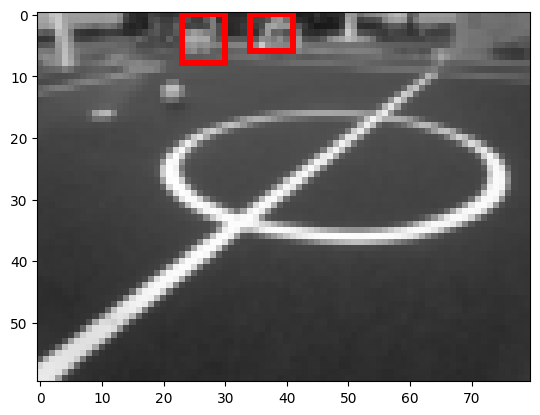

data/raw/val/images/robby_ball_far0576.png


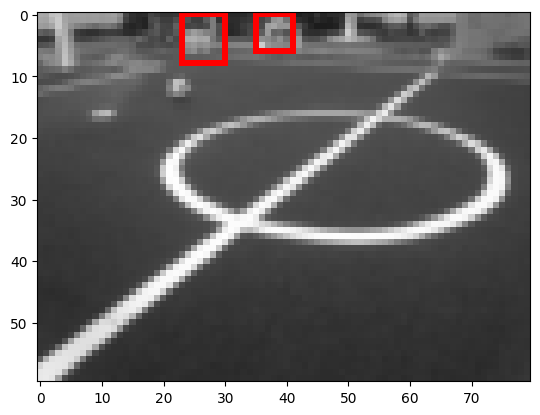

data/raw/val/images/robby_ball_far0582.png


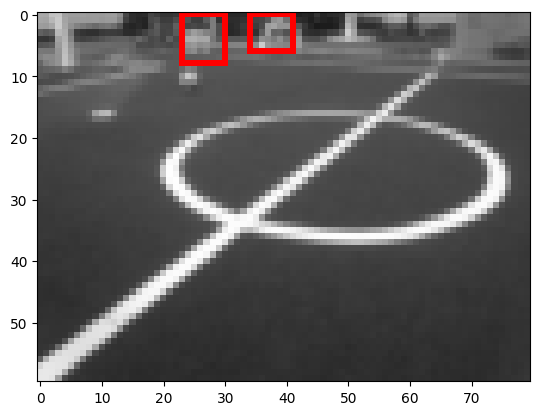

data/raw/val/images/robby_ball_far0585.png


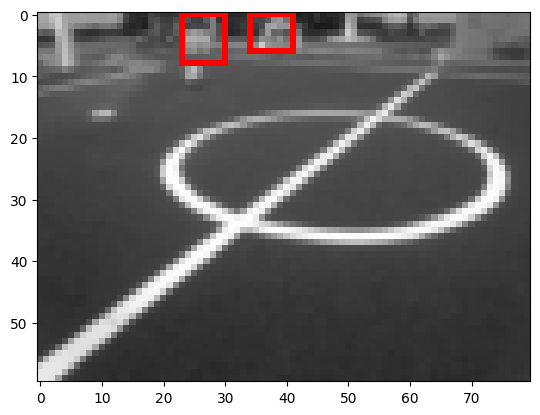

data/raw/val/images/robby_ball_far0601.png


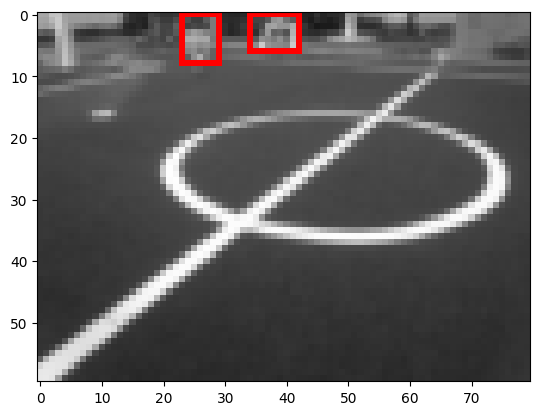

data/raw/val/images/robby_ball_far0603.png


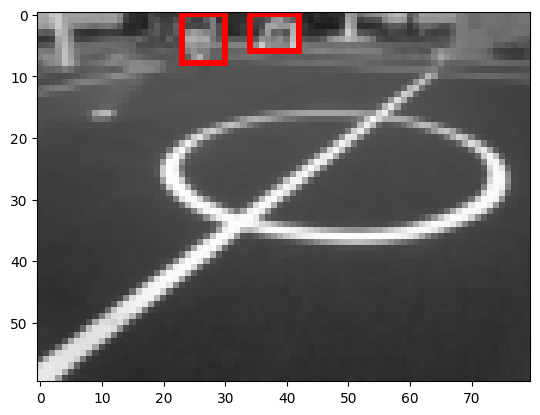

data/raw/val/images/robby_ball_far0611.png


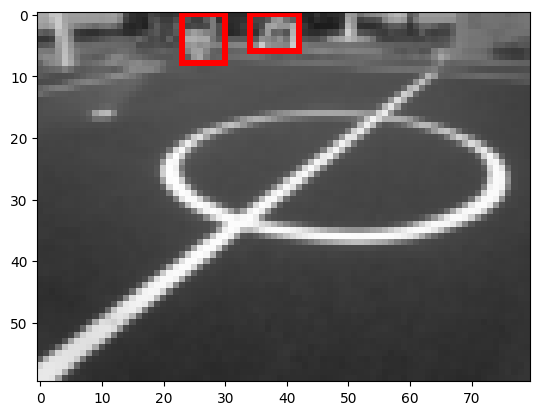

accuracy is:  0.04756511891279728


In [26]:
correct = 0
total = 0
for image, image_tensor, target_bb, target_class, image_paths in data_module.val_dataloader():
    total += len(image)
    
    predicted_boxes, predicted_logits = loaded_model.model(image)

    predicted_classes = utils.calculate_predicted_classes(predicted_logits)
    # sorted_softmax = torch.sort(softmax[0][:,1], descending=True).indices

    decoded_boxes = encoder.decode(predicted_boxes).squeeze()

    for i in range(len(image)):
        
        image_pil = T.ToPILImage()(image[i]).convert('RGB')

        if len(decoded_boxes[i][predicted_classes[i] > 0]) > 0:
            draw = draw_bounding_boxes(image_pil, decoded_boxes[i][predicted_classes[i] > 0])
            print(image_paths[i])
            correct += 1
            plt.imshow(image_pil)
            plt.show()

print("accuracy is: ", correct / total)


#### Check for duplicate prediction logits

In [ ]:
equal_count = 0

for i in range(127):
    for j in range(i + 1, 128):
        print(predicted_logits[i])
        print(predicted_logits[j])
        if not torch.all(predicted_logits[i].eq(predicted_logits[j])):

            equal_count += 1

print(f'{equal_count} of the 128 predictions are not equal to each other')


## Main Branch

In [ ]:
%load_ext autoreload
%autoreload 2
import os

import torch
from torch.utils.data import DataLoader
from datasets import TransformedRoboEireanData, RoboEireanDataWithEncoder
import utils
from pytorch_lightning.callbacks import RichProgressBar
import pytorch_lightning as pl
from models import MultiClassJetNet
import torchvision.transforms as T
import matplotlib.pyplot as plt



from PIL import ImageDraw, Image

import matplotlib.patches as patches

import torch.nn.functional as F
import torchvision.transforms as T

from visualize import draw_bounding_box
torch.manual_seed(2)

### Load Raw RoboEirean Data

In [ ]:
# Default scalings for the default boxes determined by k-means clustering
default_box_scalings = torch.tensor(
    [
        [0.06549374, 0.12928654],
        [0.11965626, 0.26605093],
        [0.20708716, 0.38876095],
        [0.31018215, 0.47485098],
        [0.415882, 0.8048184],
        [0.7293086, 0.8216225],
    ]
)


classes = ["robot"]
encoder = utils.Encoder(default_box_scalings, ["robot"])

image_transforms = T.Compose(
            [
                T.Grayscale(),
                T.PILToTensor(),
                T.ConvertImageDtype(torch.float32),
                T.Resize((60, 80)),
            ]
        )
bounding_box_transforms = T.Compose([])

raw_train_data = RoboEireanDataWithEncoder(os.path.join("data", "raw", "train"),
                                           encoder,
                                           ["robot"], image_transforms=image_transforms, bounding_box_transforms=bounding_box_transforms)

raw_val_data = RoboEireanDataWithEncoder(os.path.join("data", "raw", "val"),
                                           encoder,
                                           ["robot"], image_transforms=image_transforms, bounding_box_transforms=bounding_box_transforms)
train_loader = DataLoader(
    raw_train_data, batch_size=32, shuffle=True, num_workers=1
)
val_loader = DataLoader(
    raw_val_data, batch_size=32, shuffle=False, num_workers=1
)

### Load Model Checkpoint and Dataloaders

In [ ]:
learning_rate = 2e-3
version = 28

checkpoint = os.listdir(f"lightning_logs/version_{version}/checkpoints")[0]
trained_model = MultiClassJetNet.load_from_checkpoint(f"lightning_logs/version_{version}/checkpoints/{checkpoint}", num_classes=len(classes), num_boxes=6, learning_rate=learning_rate)
trained_model.eval()

### Bounding Box Draw Function

In [ ]:
from PIL import Image, ImageDraw

def draw_bounding_boxes(image, bounding_boxes):
    # Open the image
    draw = ImageDraw.Draw(image)
    width, height = image.size
    
    # Iterate over the bounding boxes
    for bbox in bounding_boxes:
        # Extract the box coordinates
        x_center, y_center, box_width, box_height = bbox
        
        # Convert YOLO coordinates to absolute coordinates
        x_min = (x_center - box_width / 2) * width
        y_min = (y_center - box_height / 2) * height
        x_max = (x_center + box_width / 2) * width
        y_max = (y_center + box_height / 2) * height
        
        # Draw the bounding box
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red")
    
    return image


### Draw Positive Predictions and Respective Raws

In [ ]:
for images, encoded_bounding_boxes, target_mask, target_classes, image_paths in val_loader:

    with torch.no_grad():
        predicted_boxes, predicted_logits = trained_model(images)

    predicted_classes, softmax = utils.calculate_predicted_classes(predicted_logits)

    decoded_boxes, encoded_predicted_classes, is_object = encoder.decode_model_output(predicted_boxes, predicted_classes)

    decoded_boxes = decoded_boxes.view(len(images), 480, 4)
    is_object = is_object.view(len(images), 480)
    encoded_predicted_classes = encoded_predicted_classes.view(len(images), 480)

    for i in range(len(images)):

        image_pil = T.ToPILImage()(images[i][0]).convert('RGB')

        if len(decoded_boxes[i][is_object[i]]) > 0:

            print(image_paths[i])
            draw = draw_bounding_boxes(image_pil, decoded_boxes[i][is_object[i]])

            raw_image = Image.open(image_paths[i])

            plt.imshow(raw_image)
            plt.show()
            plt.imshow(image_pil)
            plt.show()
